## 1. Importing Libraries

In [1]:
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
plt.rcParams['axes.grid'] = False

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
print(torch.cuda.is_available())

1
Tesla T4
True


In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


## 2. Data Collection

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

train_data = ImageFolder(root='/content/drive/MyDrive/Projects/Dogs-vs-Cats/train', transform=train_transforms)
valid_data = ImageFolder(root='/content/drive/MyDrive/Projects/Dogs-vs-Cats/valid', transform=valid_transforms)
test_data = ImageFolder(root='/content/drive/MyDrive/Projects/Dogs-vs-Cats/test', transform=test_transforms)

batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

classes = train_data.classes

In [7]:
mean = torch.tensor([0.485, 0.456, 0.406]).view((3, 1, 1))
std = torch.tensor([0.229, 0.224, 0.225]).view((3, 1, 1))

data_loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}
data_sizes = {'train': len(train_data), 'valid': len(valid_data), 'test': len(test_data)}

## 3. Data Overview


In [8]:
print(f'Number of training images: {len(train_data)}')
print(f'Number of validation images: {len(valid_data)}')
print(f'Number of test images: {len(test_data)}')
print(f'Number of classes: {len(classes)}')

Number of training images: 3600
Number of validation images: 1200
Number of test images: 1200
Number of classes: 2


In [9]:
classes

['cats', 'dogs']

In [10]:
def imshow(tup, classes, mean, std):
    d = {idx: classes[idx] for idx in range(len(classes))}
    tensor, title = tup[0], d[tup[1]]
    tensor = std * tensor + mean

    plt.imshow(tensor.permute((1, 2, 0)))
    plt.title(title)
    plt.axis('off')

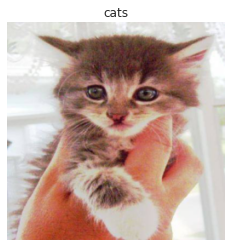

In [11]:
imshow(train_data[3], classes, mean, std)

## 4. Deep Learning

In [12]:
def train_valid_model(data_loaders, data_sizes, model, criterion, optimizer, scheduler, num_epochs, print_time=True, device='cuda:0'):
    since = time.time()

    model.to(device)

    train_loss_epochs = []
    valid_loss_epochs = []
    train_accuracy_epochs = []
    valid_accuracy_epochs = []
    
    best_accuracy = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct = 0
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data).item()
  
            if phase == 'train':
                scheduler.step()

            loss_epoch = running_loss / data_sizes[phase]
            accuracy_epoch = running_correct / data_sizes[phase]
            if phase == 'train':
                train_loss_epochs.append(loss_epoch)
                train_accuracy_epochs.append(accuracy_epoch)
            elif phase == 'valid':
                valid_loss_epochs.append(loss_epoch)
                valid_accuracy_epochs.append(accuracy_epoch)

            print('{} Loss: {:.3f} Accuracy: {:.3f}'.format(phase, loss_epoch, accuracy_epoch))

            if phase == 'valid' and accuracy_epoch > best_accuracy:
                best_accuracy = accuracy_epoch
                best_model_weights = copy.deepcopy(model.state_dict())
        print()

    model.load_state_dict(best_model_weights)
    print('\nBest valid Accuracy: {:.3f}'.format(best_accuracy))

    time_elapsed = time.time() - since
    if print_time:
        print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, train_loss_epochs, valid_loss_epochs, train_accuracy_epochs, valid_accuracy_epochs

In [13]:
def test(loader, classes, model, criterion, print_time=True, device='cuda:0'):
    since = time.time()

    model.to(device)
    model.eval()

    valid_loss = torch.zeros(1).to(device)
    class_correct = torch.zeros(len(classes), dtype=int) 
    class_total = torch.zeros(len(classes), dtype=int)
    for batch_i, data in enumerate(loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
    
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            valid_loss += (1 / (batch_i + 1)) * (loss - valid_loss)

            correct = preds.eq(labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    print('Test Loss: {:.3f}'.format(valid_loss.item()))
    print('Test Accuracy: {:.3f} ({}/{})\n'.format(class_correct.sum() / class_total.sum(), 
                                                   class_correct.sum(), class_total.sum()))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f} ({}/{})'.format(classes[i], class_correct[i] / class_total[i],
                                                               class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))


              
    time_elapsed = time.time() - since
    if print_time:
        print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

### 4.1. Fine Tuning

In [14]:
model_ft = models.resnet50(pretrained=True)
num_features_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features_ft, len(classes))

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
num_epochs = 10

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [15]:
model_ft, train_loss_epochs, valid_loss_epochs, train_accuracy_epochs, valid_accuracy_epochs = train_valid_model(data_loaders, data_sizes, model_ft, criterion_ft, optimizer_ft, scheduler_ft, num_epochs)

Epoch 1/10
----------
train Loss: 0.147 Accuracy: 0.944
valid Loss: 0.026 Accuracy: 0.994

Epoch 2/10
----------
train Loss: 0.028 Accuracy: 0.994
valid Loss: 0.018 Accuracy: 0.996

Epoch 3/10
----------
train Loss: 0.016 Accuracy: 0.996
valid Loss: 0.017 Accuracy: 0.993

Epoch 4/10
----------
train Loss: 0.010 Accuracy: 0.998
valid Loss: 0.014 Accuracy: 0.995

Epoch 5/10
----------
train Loss: 0.005 Accuracy: 1.000
valid Loss: 0.015 Accuracy: 0.996

Epoch 6/10
----------
train Loss: 0.006 Accuracy: 0.999
valid Loss: 0.013 Accuracy: 0.995

Epoch 7/10
----------
train Loss: 0.004 Accuracy: 0.999
valid Loss: 0.015 Accuracy: 0.994

Epoch 8/10
----------
train Loss: 0.002 Accuracy: 1.000
valid Loss: 0.013 Accuracy: 0.995

Epoch 9/10
----------
train Loss: 0.003 Accuracy: 1.000
valid Loss: 0.012 Accuracy: 0.996

Epoch 10/10
----------
train Loss: 0.003 Accuracy: 1.000
valid Loss: 0.012 Accuracy: 0.997


Best valid Accuracy: 0.997
Complete in 12m 23s


In [16]:
test(test_loader, classes, model_ft, criterion_ft)

Test Loss: 0.022
Test Accuracy: 0.991 (1189/1200)

Test Accuracy of cats: 0.992 (595/600)
Test Accuracy of dogs: 0.990 (594/600)
Complete in 0m 55s


In [17]:
def plot(train, valid, num_epochs, title):
    plt.plot(torch.arange(1, num_epochs + 1), train, label='training')
    plt.plot(torch.arange(1, num_epochs + 1), valid, label='validation')

    plt.xlabel('epoch')
    plt.ylabel(title)
    plt.legend()

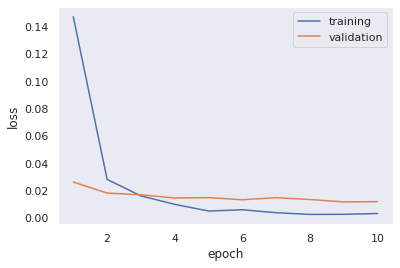

In [18]:
plot(train_loss_epochs, valid_loss_epochs, num_epochs, 'loss')

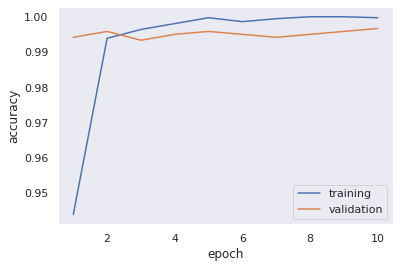

In [19]:
plot(train_accuracy_epochs, valid_accuracy_epochs, num_epochs, 'accuracy')

## 4.2. Feature Extraction

In [20]:
model_fe = models.resnet50(pretrained=True)

for param in model_fe.parameters():
    param.requires_grad = False

num_features_fe = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_features_fe, len(classes))

criterion_fe = nn.CrossEntropyLoss()
optimizer_fe = optim.Adam(model_fe.fc.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08)
scheduler_fe = lr_scheduler.StepLR(optimizer_fe, step_size=7, gamma=0.1)
num_epochs = 10

In [21]:
model_fe, train_loss_epochs, valid_loss_epochs, train_accuracy_epochs, valid_accuracy_epochs = train_valid_model(data_loaders, data_sizes, model_fe, criterion_fe, optimizer_fe, scheduler_fe, num_epochs)

Epoch 1/10
----------
train Loss: 3.490 Accuracy: 0.910
valid Loss: 1.099 Accuracy: 0.959

Epoch 2/10
----------
train Loss: 1.354 Accuracy: 0.961
valid Loss: 1.170 Accuracy: 0.963

Epoch 3/10
----------
train Loss: 0.685 Accuracy: 0.973
valid Loss: 0.808 Accuracy: 0.973

Epoch 4/10
----------
train Loss: 1.553 Accuracy: 0.962
valid Loss: 0.273 Accuracy: 0.993

Epoch 5/10
----------
train Loss: 0.911 Accuracy: 0.977
valid Loss: 0.331 Accuracy: 0.993

Epoch 6/10
----------
train Loss: 0.387 Accuracy: 0.984
valid Loss: 0.305 Accuracy: 0.989

Epoch 7/10
----------
train Loss: 1.195 Accuracy: 0.971
valid Loss: 0.363 Accuracy: 0.991

Epoch 8/10
----------
train Loss: 0.404 Accuracy: 0.985
valid Loss: 0.342 Accuracy: 0.993

Epoch 9/10
----------
train Loss: 0.468 Accuracy: 0.985
valid Loss: 0.433 Accuracy: 0.988

Epoch 10/10
----------
train Loss: 0.435 Accuracy: 0.986
valid Loss: 0.325 Accuracy: 0.993


Best valid Accuracy: 0.993
Complete in 4m 46s


In [22]:
test(test_loader, classes, model_fe, criterion_fe)

Test Loss: 0.696
Test Accuracy: 0.983 (1179/1200)

Test Accuracy of cats: 0.983 (590/600)
Test Accuracy of dogs: 0.982 (589/600)
Complete in 0m 8s


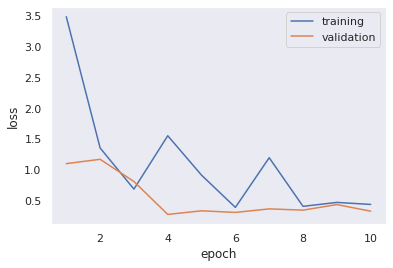

In [23]:
plot(train_loss_epochs, valid_loss_epochs, num_epochs, 'loss')

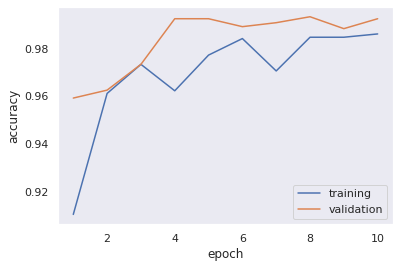

In [24]:
plot(train_accuracy_epochs, valid_accuracy_epochs, num_epochs, 'accuracy')

## 5. Visualization

In [25]:
def visualize_model(loader, classes, model, mean, std, num_images):
    train_mode = model.training
    model.eval()

    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inputs = inputs.cpu()
            
            for idx in range(inputs.size()[0]):
                tensor = std * inputs[idx] + mean

                plt.subplot(-(-num_images // 5), 5, idx + 1)
                plt.imshow(tensor.permute((1, 2, 0)))
                plt.title(f'predicted: {classes[preds[idx]]}')
                plt.axis('off')

                if idx + 1 == num_images:
                    model.train(mode=train_mode)
                    return 

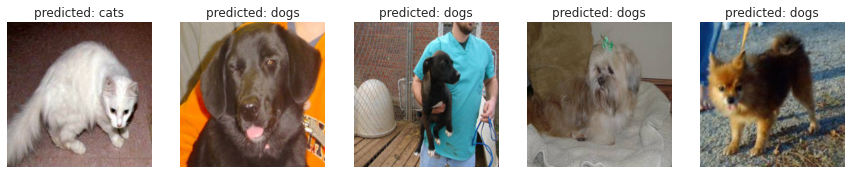

In [26]:
visualize_model(data_loaders['test'], classes, model_ft, mean, std, num_images=5)

In [27]:
def show_filter(weights, channel, color, num_filters):
    if num_filters > weights.size(0):
        return "Number of filters isn't correct!"
      
    weights = weights.data.cpu().numpy()
    plt.figure(figsize=(15, 10))

    for idx in range(num_filters):
        plt.subplot(-(-num_filters // 5), 5, idx + 1)
        weight = weights[idx][channel] if channel != 3 else (weights[idx].transpose((1, 2, 0)) * 255).astype('uint8')
        plt.imshow(weight, cmap=color)

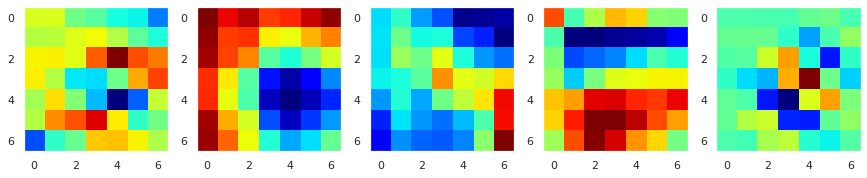

In [28]:
show_filter(model_ft.conv1.weight, channel=0, color='jet', num_filters=5)

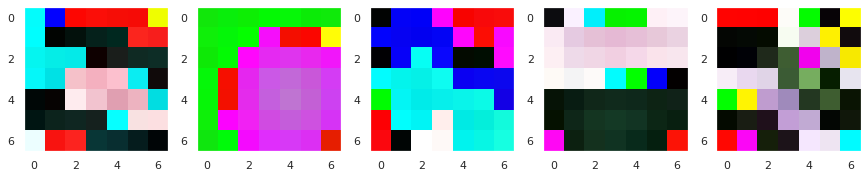

In [29]:
show_filter(model_ft.conv1.weight, channel=3, color='jet', num_filters=5)

In [30]:
def activation_map(loader, weights, mean, std, channel, color, num_filters):
    data_iter = iter(loader)
    inputs, labels = data_iter.next()
    rand_idx = np.random.randint(0, 32)

    weights = weights.data.cpu().numpy()
    tensor = inputs[rand_idx]
    
    plt.imshow((std * tensor + mean).permute((1, 2, 0)))  
    plt.figure(figsize=(30, 10))

    for idx in range(2 * num_filters):
        plt.subplot(-(-num_filters // 5), 2 * 5, idx + 1)

        if idx % 2 == 0:
            weight = weights[int(idx / 2)][channel]
            plt.imshow(weight, cmap=color)
        else:
            conv_img = cv.filter2D(tensor.permute((1, 2, 0)).numpy(), -1, weights[int((idx - 1) / 2)][channel])
            plt.imshow(conv_img, cmap=color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

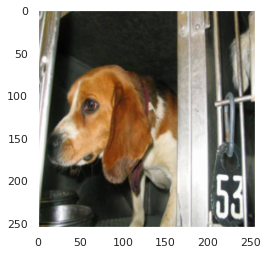

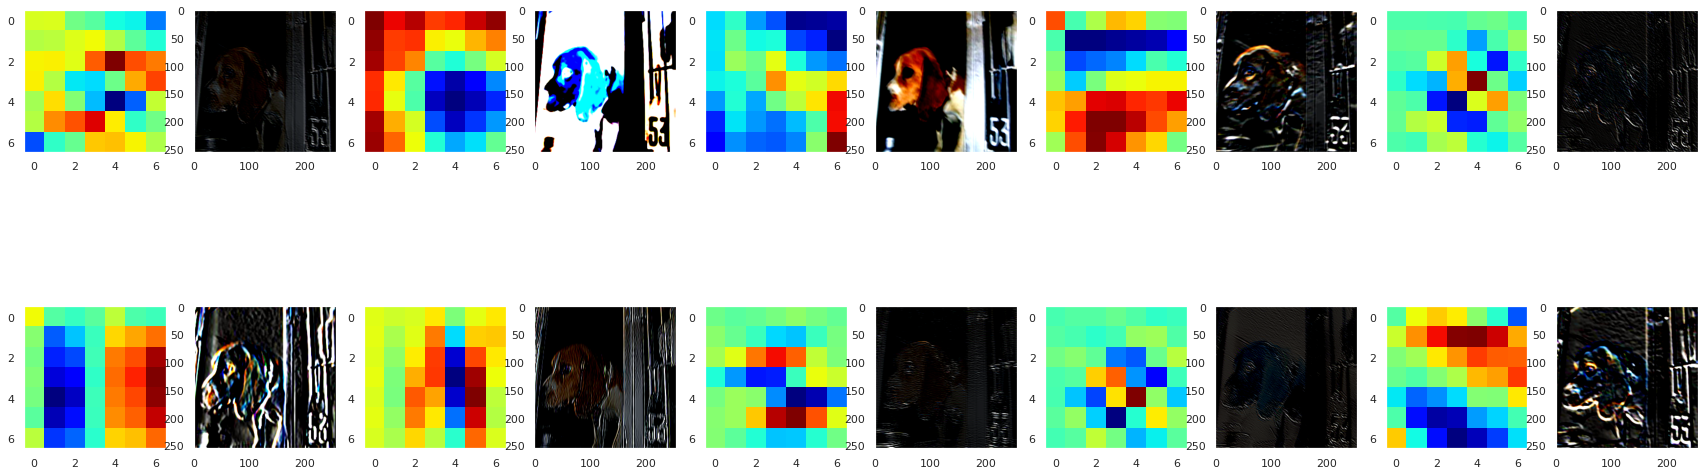

In [31]:
activation_map(test_loader, model_ft.conv1.weight, mean, std, channel=0, color='jet', num_filters=10)